In [1]:
from DDPG_agent import DDPGAgent, RandomAgent
import torch
from classes import ActorNetwork, CriticNetwork
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from utils import running_average

In [6]:
env = gym.make('LunarLanderContinuous-v3')
print("env made")
# If you want to render the environment while training run instead:
# env = gym.make('LunarLander-v2', render_mode = "human")
discount_factor = 0.99
env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]
q_agent = DDPGAgent(action_dim, state_dim, max_action, gamma=discount_factor)

env made


In [10]:
# Path to the saved trained weights
trained_weights_path = './neural-network-2-actor.pth'

# Initialize a new instance of the network
trained_network = ActorNetwork(state_dim=state_dim, action_dim=action_dim)

# Load the trained weights into the network
#trained_network.load(torch.load(trained_weights_path))
model = torch.load('neural-network-2-actor.pth')
# Set the network to evaluation mode
model.eval()

# Replace the agent's network with the trained network
q_agent.actor = model

/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_96846/4052055534.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('neural-network-2-actor.pt

Episode 299 - Reward/Steps: -108.4/68 - Avg. Reward/Steps: -180.8/68: 100%|██████████| 300/300 [00:02<00:00, 131.99it/s]  


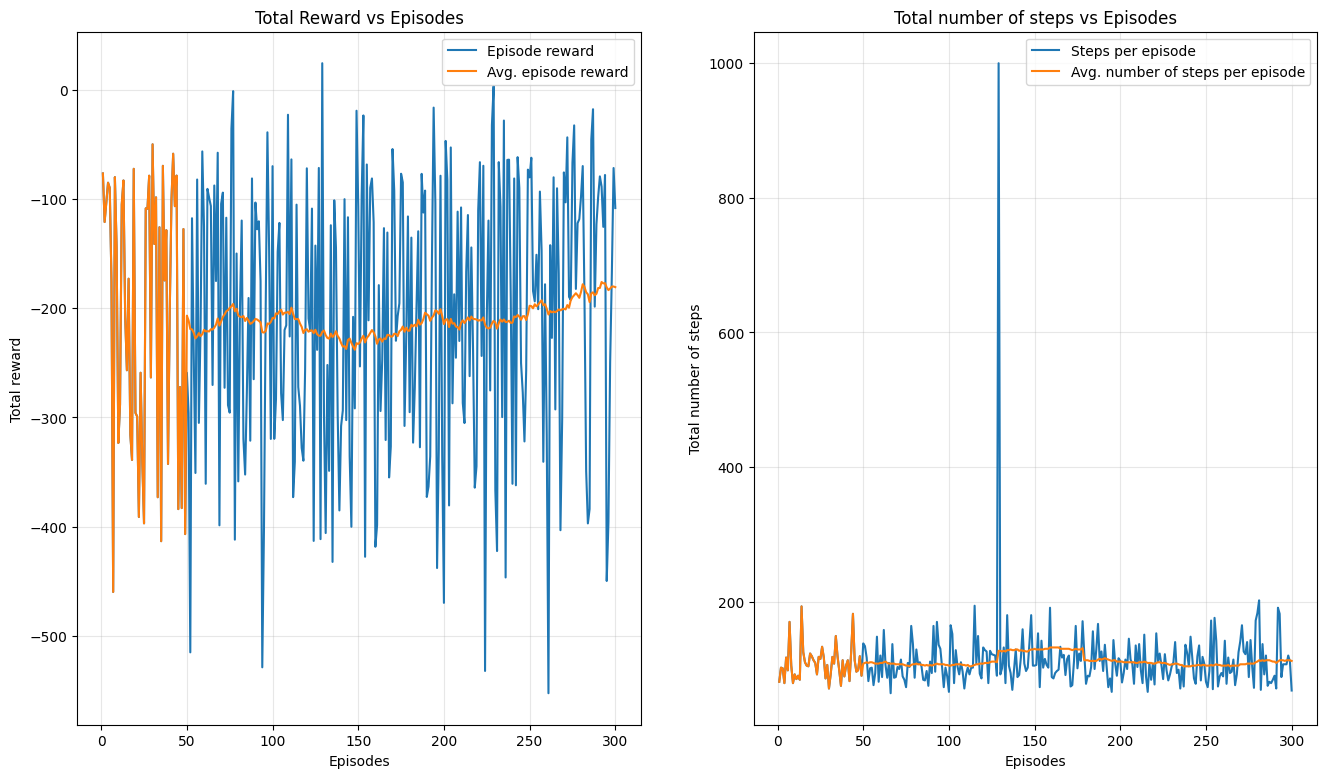

In [21]:
# Random agent initialization
env = gym.make('LunarLanderContinuous-v3')
random_agent = RandomAgent(action_dim)
N_episodes = 300
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = [] 
n_ep_running_average = 50      
### Training process
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)

for episode in EPISODES:
    # Reset environment data and initialize variables
    done, truncated = False, False
    state = env.reset()[0]
    total_episode_reward = 0.
    t = 0
    while not (done or truncated):
        # Take a random action
        action = random_agent.forward(state)
        action = np.clip(action, env.action_space.low, env.action_space.high)
        # Get next state and reward
        next_state, reward, done, truncated, _ = env.step(action)

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state
        t += 1

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    avg_reward = running_average(episode_reward_list, n_ep_running_average)[-1]

    # Update progress bar
    EPISODES.set_description(
        f"Episode {episode} - Reward/Steps: {total_episode_reward:.1f}/{t} - Avg. Reward/Steps: {avg_reward:.1f}/{t}")

# Close environment
env.close()

# Plot Rewards and Steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

# Use the length of episode_reward_list for the x-axis
x_range = range(1, len(episode_reward_list) + 1)

ax[0].plot(x_range, episode_reward_list, label='Episode reward')
ax[0].plot(x_range, running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(x_range, episode_number_of_steps, label='Steps per episode')
ax[1].plot(x_range, running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_plot_agents(ddpg_agent, random_agent, env, n_eval_episodes=50):
    """
    Evaluate and compare the total episodic rewards of a DDPG agent and a RandomAgent over multiple episodes,
    and plot the average rewards as a bar chart.

    Args:
        ddpg_agent (DDPGAgent): The trained DDPG agent.
        random_agent (RandomAgent): The random action agent.
        env (gym.Env): The environment to evaluate the agents on.
        n_eval_episodes (int): Number of episodes to evaluate.

    Returns:
        None: Displays a bar chart comparing the average episodic rewards.
    """
    def evaluate_agent(agent, n_episodes, use_actor=False):
        """Evaluate a single agent over multiple episodes."""
        rewards = []
        for _ in range(n_episodes):
            state = env.reset()[0]  # Reset the environment
            total_reward = 0
            done, truncated = False, False
            while not (done or truncated):
                if use_actor:
                    # Use DDPG agent's actor network to select an action
                    state_tensor = torch.tensor([state], dtype=torch.float32)
                    with torch.no_grad():
                        action = ddpg_agent.actor(state_tensor).detach().cpu().numpy().flatten()
                else:
                    # Use RandomAgent's forward method to select an action
                    action = random_agent.forward(state)
                
                # Clip the action to the environment's action space
                action = np.clip(action, env.action_space.low, env.action_space.high)
                
                # Step the environment
                state, reward, done, truncated, _ = env.step(action)
                total_reward += reward
            rewards.append(total_reward)
        return rewards

    # Set the DDPG agent's actor network to evaluation mode
    ddpg_agent.actor.eval()

    # Evaluate both agents
    print("Evaluating DDPG agent...")
    ddpg_agent_rewards = evaluate_agent(ddpg_agent, n_eval_episodes, use_actor=True)
    ddpg_agent_avg_reward = np.mean(ddpg_agent_rewards)

    print("Evaluating Random agent...")
    random_agent_rewards = evaluate_agent(random_agent, n_eval_episodes)
    random_agent_avg_reward = np.mean(random_agent_rewards)

    # Plot average rewards as a bar chart
    agents = ['DDPG Agent', 'Random Agent']
    avg_rewards = [ddpg_agent_avg_reward, random_agent_avg_reward]

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(agents, avg_rewards, color=['blue', 'orange'])

    # Add labels on top of the bars
    for bar, reward in zip(bars, avg_rewards):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position
            bar.get_height() + (5 if reward >= 0 else -15),  # Y position
            f'{reward:.3f}',  # Text
            ha='center', va='bottom' if reward >= 0 else 'top', fontsize=12
        )

    # Add labels and title
    ax.set_ylabel('Average Episodic Reward', fontsize=14)
    ax.set_title('Performance Comparison: DDPG Agent vs. Random Agent', fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print average rewards
    print(f"Average Reward over {n_eval_episodes} Episodes:")
    print(f"DDPG Agent: {ddpg_agent_avg_reward:.2f}")
    print(f"Random Agent: {random_agent_avg_reward:.2f}")

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_agents(ddpg_agent, random_agent, env, n_eval_episodes=50):
    """
    Evaluate and compare the total episodic rewards of a DDPG agent and a RandomAgent over multiple episodes.

    Args:
        ddpg_agent (DDPGAgent): The trained DDPG agent.
        random_agent (RandomAgent): The random action agent.
        env (gym.Env): The environment to evaluate the agents on.
        n_eval_episodes (int): Number of episodes to evaluate.

    Returns:
        None: Displays a plot of the episodic rewards.
    """
    def evaluate_agent(agent, n_episodes, use_actor=False):
        """Evaluate a single agent over multiple episodes."""
        rewards = []
        for _ in range(n_episodes):
            state = env.reset()[0]  # Reset the environment
            total_reward = 0
            done, truncated = False, False
            while not (done or truncated):
                if use_actor:
                    # Use DDPG agent's actor network to select an action
                    state_tensor = torch.tensor([state], dtype=torch.float32)
                    with torch.no_grad():
                        action = ddpg_agent.actor(state_tensor).detach().cpu().numpy().flatten()
                else:
                    # Use RandomAgent's forward method to select an action
                    action = random_agent.forward(state)
                
                # Clip the action to the environment's action space
                action = np.clip(action, env.action_space.low, env.action_space.high)
                
                # Step the environment
                state, reward, done, truncated, _ = env.step(action)
                total_reward += reward
            rewards.append(total_reward)
        return rewards

    # Set the DDPG agent's actor network to evaluation mode
    ddpg_agent.actor.eval()

    # Evaluate both agents
    print("Evaluating DDPG agent...")
    ddpg_agent_rewards = evaluate_agent(ddpg_agent, n_eval_episodes, use_actor=True)

    print("Evaluating Random agent...")
    random_agent_rewards = evaluate_agent(random_agent, n_eval_episodes)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(range(1, n_eval_episodes + 1), ddpg_agent_rewards, label="DDPG Agent", marker='o')
    plt.plot(range(1, n_eval_episodes + 1), random_agent_rewards, label="Random Agent", marker='x')

    plt.xlabel('Episode')
    plt.ylabel('Total Episodic Reward')
    plt.title('Comparison of DDPG Agent and Random Agent')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Print average rewards
    print(f"Average Reward over {n_eval_episodes} Episodes:")
    print(f"DDPG Agent: {np.mean(ddpg_agent_rewards):.2f}")
    print(f"Random Agent: {np.mean(random_agent_rewards):.2f}")

In [ ]:
# Load the environment
env = gym.make('LunarLanderContinuous-v3')


/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_59740/4030816361.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_agent.network.load_state_dict(torch.load('

Evaluating DDPG agent...
Evaluating Random agent...


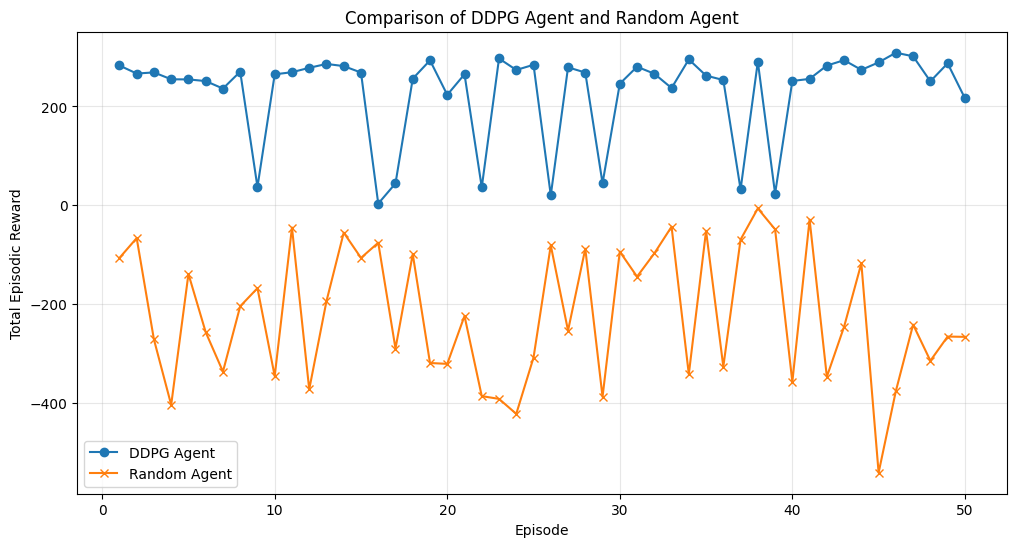

Average Reward over 50 Episodes:
DDPG Agent: 231.07
Random Agent: -220.84


In [26]:
evaluate_agents(q_agent, random_agent, env, n_eval_episodes=50)

Evaluating DDPG agent...
Evaluating Random agent...


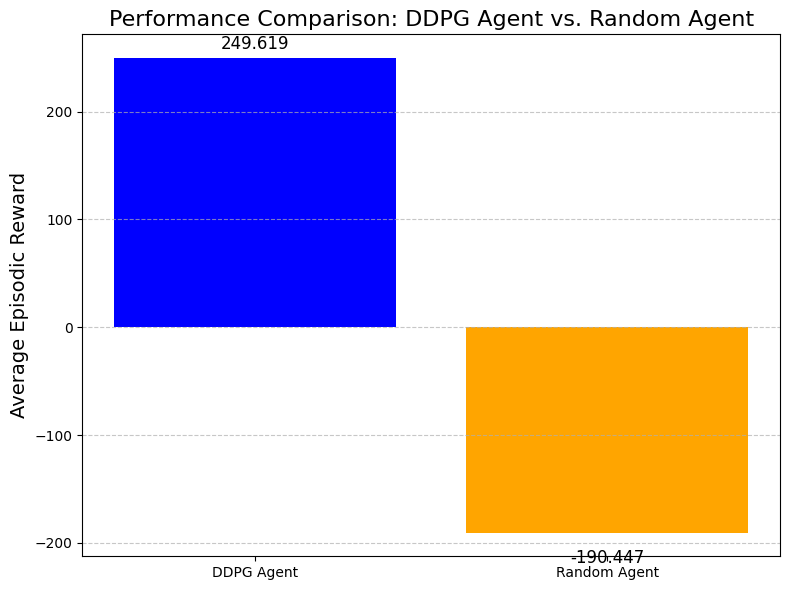

Average Reward over 50 Episodes:
DDPG Agent: 249.62
Random Agent: -190.45


In [29]:
# Assume env, q_agent, and random_agent are already initialized
evaluate_and_plot_agents(q_agent, random_agent, env, n_eval_episodes=50)

In [2]:
from training1 import ddpg_training
env = gym.make('LunarLanderContinuous-v3')
# If you want to render the environment while training run instead:
# env = gym.make('LunarLanderContinuous-v2', render_mode = "human")

env.reset()

# Parameters
N_episodes = 500               # Number of episodes to run for training
discount_factor = 0.95         # Value of gamma
n_ep_running_average = 50      # Running average of 50 episodes
m = len(env.action_space.high) # dimensionality of the action
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]
print("m is: ", m, "action dim is: ", action_dim)
buffer_size=5000
agent = DDPGAgent(state_dim, action_dim, max_action, gamma=0.99, buffer_size=buffer_size)
# Reward

# Agent initialization
#agent = RandomAgent(m)

# Training process

#episode_reward_list, episode_number_of_steps = random_training(N_episodes, env, agent, n_ep_running_average)
episode_reward_list, episode_number_of_steps = ddpg_training(N_episodes, env, agent, n_ep_running_average)

m is:  2 action dim is:  2


Episode:   0%|          | 0/500 [00:00<?, ?it/s]/Users/carlottaholzle/Desktop/Reinforcement Learning/lab2/problem2/DDPG_agent.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)
Episode 499 - Reward/Steps: 242.7/617 - Avg. Reward/Steps: 233.0/426: 100%|██████████| 500/500 [11:57<00:00,  1.44s/it]   


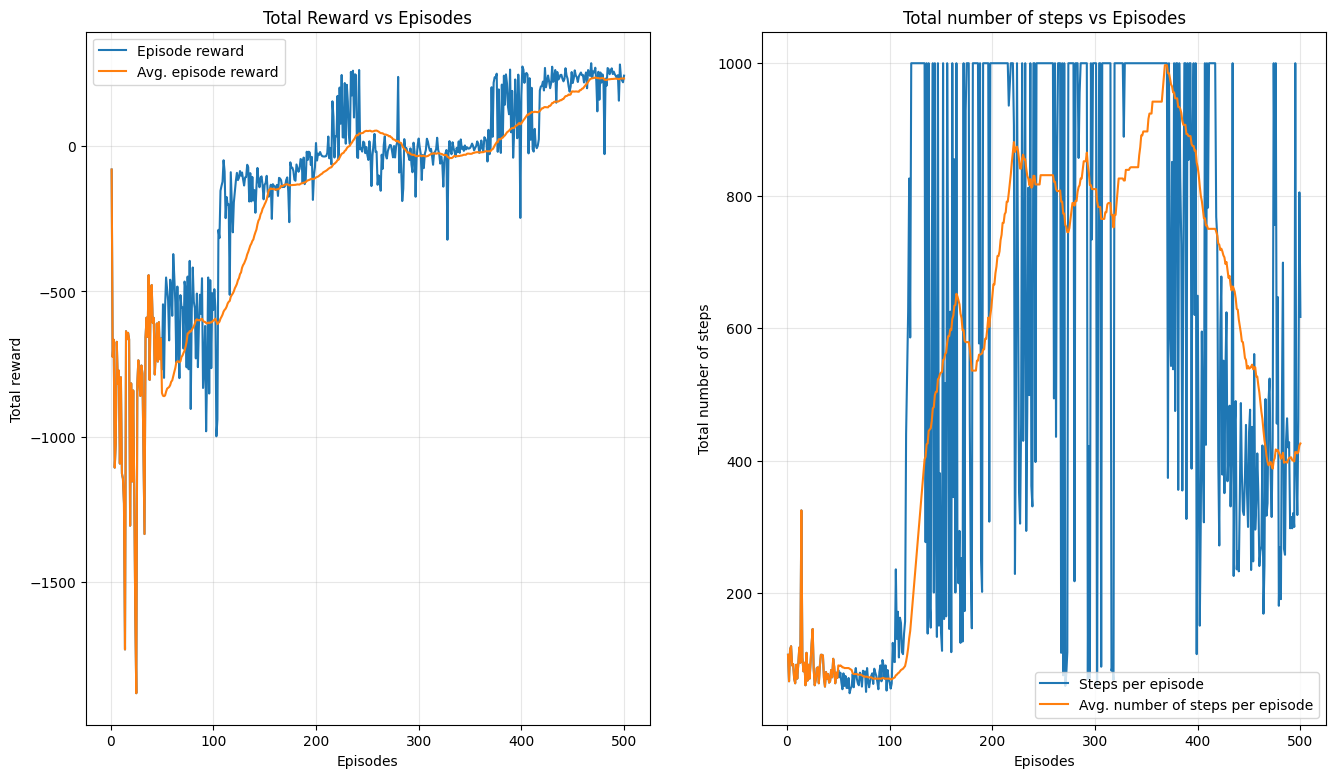

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_70017/2403081364.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_tensor = torch.tensor(action, dtype=torch.float32)


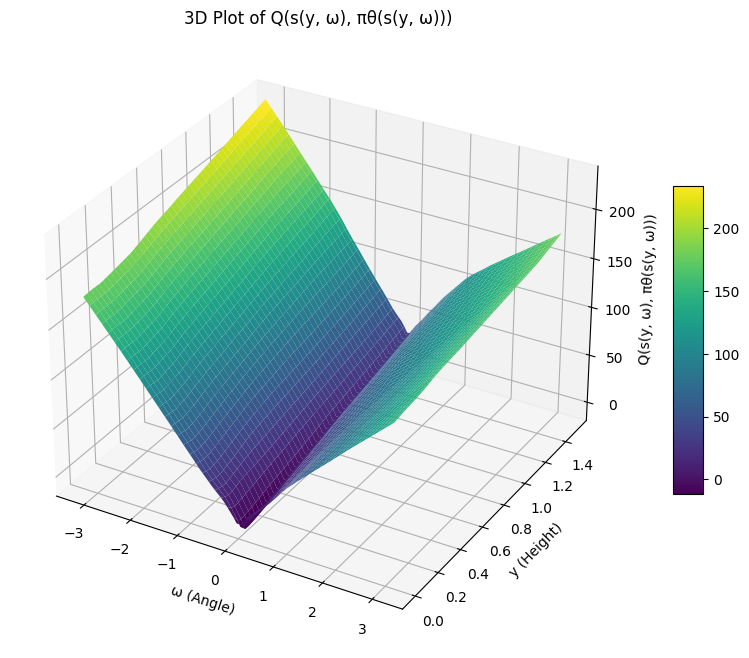

In [ ]:
# Set the actor network to evaluation mode
#
#ddpg_agent = DDPGAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action)
#actor = torch.load('neural-network-2-actor.pth')
# critic = torch.load('neural-network-2-critic.pth')
# agent.critic = critic
#agent.actor = actor

agent.actor.eval()
env.reset()
# Set up grid for y and ω
y_vals = np.linspace(0, 1.5, 100)  # Height of the lander
omega_vals = np.linspace(-np.pi, np.pi, 100)  # Angle of the lander
y_grid, omega_grid = np.meshgrid(y_vals, omega_vals)

# Initialize an array to store Q values
q_values_grid = np.zeros_like(y_grid)

# Compute Q values
for i, y in enumerate(y_vals):
    for j, omega in enumerate(omega_vals):
        # Construct the restricted state vector s(y, ω)
        state = np.array([0, y, 0, 0, omega, 0, 0, 0], dtype=np.float32)
        state_tensor = torch.tensor([state], dtype=torch.float32)

        # Compute the action using the actor network
        with torch.no_grad():
            action = agent.actor(state_tensor).detach().cpu()

        # Compute the Q-value using the critic network
        action_tensor = torch.tensor(action, dtype=torch.float32)
        with torch.no_grad():
            q_value = agent.critic(state_tensor, action_tensor).item()

        # Store the Q-value
        q_values_grid[j, i] = q_value

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
surf = ax.plot_surface(omega_grid, y_grid, q_values_grid, cmap='viridis')

# Label axes
ax.set_xlabel('ω (Angle)')
ax.set_ylabel('y (Height)')
ax.set_zlabel('Q(s(y, ω), πθ(s(y, ω)))')
ax.set_title('3D Plot of Q(s(y, ω), πθ(s(y, ω)))')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.savefig("./figures/value_function.pdf")
plt.show()

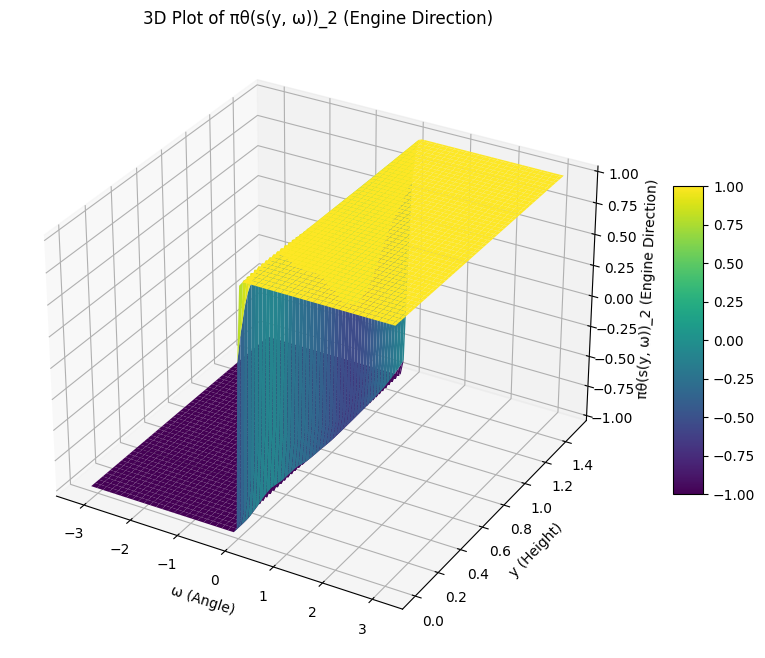

In [8]:
env.reset()
# Set up grid for y and ω
y_vals = np.linspace(0, 1.5, 100)  # Height of the lander
omega_vals = np.linspace(-np.pi, np.pi, 100)  # Angle of the lander
y_grid, omega_grid = np.meshgrid(y_vals, omega_vals)

# Initialize an array to store engine direction values (second action element)
engine_directions = np.zeros_like(y_grid)

# Compute the engine direction values
for i, y in enumerate(y_vals):
    for j, omega in enumerate(omega_vals):
        # Construct the restricted state vector s(y, ω)
        state = np.array([0, y, 0, 0, omega, 0, 0, 0], dtype=np.float32)
        state_tensor = torch.tensor([state], dtype=torch.float32)

        # Compute the action using the actor network
        with torch.no_grad():
            action = agent.actor(state_tensor).detach().cpu().numpy().flatten()

        # Extract the second element of the action (engine direction)
        engine_directions[j, i] = action[1]

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
surf = ax.plot_surface(omega_grid, y_grid, engine_directions, cmap='viridis')

# Label axes
ax.set_xlabel('ω (Angle)')
ax.set_ylabel('y (Height)')
ax.set_zlabel('πθ(s(y, ω))_2 (Engine Direction)')
ax.set_title('3D Plot of πθ(s(y, ω))_2 (Engine Direction)')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.savefig("./figures/policy_function_ddpg.pdf")
plt.show()

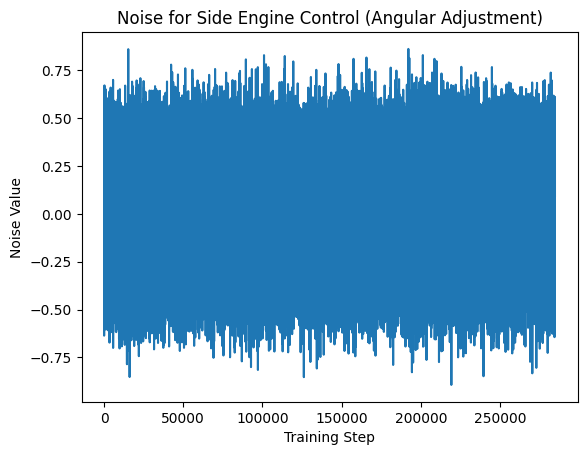

In [12]:
angular_action_index = 1  # Side engine control (affects angular recovery)
plt.plot(range(len(agent.noise_values)), [n[angular_action_index] for n in agent.noise_values])
plt.title("Noise for Side Engine Control (Angular Adjustment)")
plt.xlabel("Training Step")
plt.ylabel("Noise Value")
plt.show()

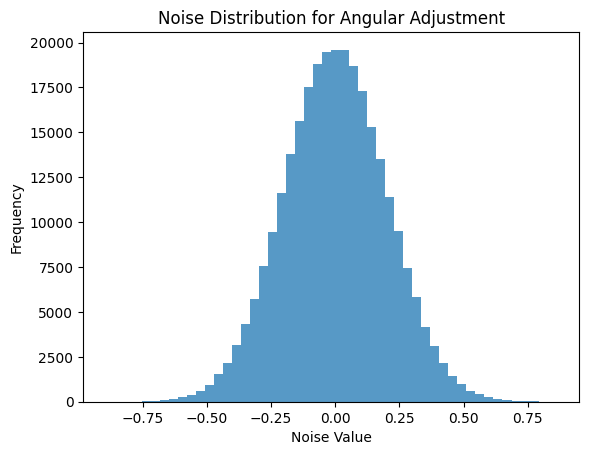

Mean of angular noise: 0.0007873081066732082


In [13]:


# Extract noise values for the side engine
angular_noise = [n[angular_action_index] for n in agent.noise_values]

# Plot histogram
plt.hist(angular_noise, bins=50, alpha=0.75)
plt.title("Noise Distribution for Angular Adjustment")
plt.xlabel("Noise Value")
plt.ylabel("Frequency")
plt.show()

# Calculate the mean of the noise to check for bias
print(f"Mean of angular noise: {np.mean(angular_noise)}")

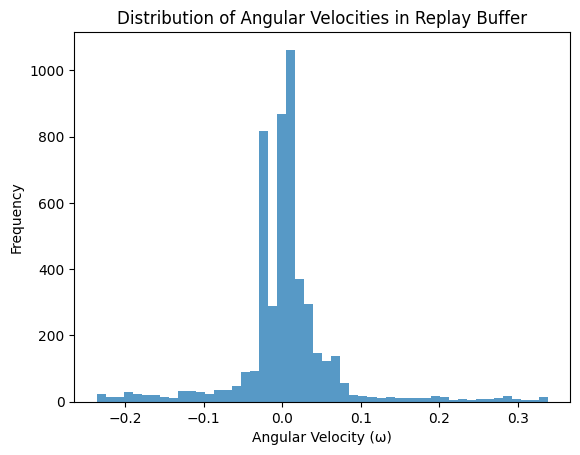

In [11]:
omega_values = [s[4] for s in agent.replay_buffer.get_all_states()]  # Index 4 is angular velocity
plt.hist(omega_values, bins=50, alpha=0.75)
plt.title("Distribution of Angular Velocities in Replay Buffer")
plt.xlabel("Angular Velocity (ω)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
positive_omega_states = [s for s in replay_buffer.get_all_states() if s[angular_velocity_index] > 0]
positive_omega_actions = [policy(s)[angular_action_index] for s in positive_omega_states]

# Plot actions for positive angular velocity states
plt.hist(positive_omega_actions, bins=50, alpha=0.75)
plt.title("Actions for Positive Angular Velocities")
plt.xlabel("Action Value (a2)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Count occurrences of positive and negative angular velocities in the buffer
positive_count = sum(1 for s in replay_buffer.get_all_states() if s[angular_velocity_index] > 0)
negative_count = sum(1 for s in replay_buffer.get_all_states() if s[angular_velocity_index] < 0)

print(f"Positive angular velocity states: {positive_count}")
print(f"Negative angular velocity states: {negative_count}")